<span>
    <img src="https://www.inesc-id.pt/wp-content/uploads/2019/08/INESC-ID-new-logo_version-02A.png" width="110px" align="right">
    <img src="https://upload.wikimedia.org/wikipedia/pt/e/ed/IST_Logo.png" width="40px" align="right">
</span>
<span>
    <b>Authors:</b> Joana Dimas, Inês Lobo, Samuel Mascarenhas, Diogo Rato and Rui Prada <br/>
    <b>Python version:</b> 3.8.8<br/>
    <b>Scikit-learn version:</b> 0.24.1<br/>
</span>

# Dynamic Identity Model For Agents



In this notebook, the Dynamic Identity Model for Agents is explained and implemented. <b>It is relevant to mention that this notebook is not 100% comprehensive</b>.

## Table of Contents

1. [Introduction](#introduction)
    1. [Architecture](#architecture)
2. [Context and Agents](#titlectx)
    1. [Social Context](#socContext)
    2. [Agents](#agent)
    3. [Social Groups](#socialGroup)
    4. [Instantiate](#instEnvironment)
3. [Identity Salience Mechanism](#idSalienceMechanism)
    1. [Social Categorization](#socCategorization)
    2. [Normative Fit](#normativeFit)
    3. [Comparative Fit](#comparativeFit)
    4. [Salience](#salience)
    5. [Accessibility Update](#accUpdate)
    6. [Setup](#setup)
    7. [Salience and Accessibility Plots](#plots)
4. [Conclusion](#conclusion)


## Introduction <a id='introduction'></a>

The Dynamic Identity Model for Agents (DIMA) is based on the <b>Social Identity Approach</b>, aiming to provide agents with <b>multi-faceted and context-dependent identities</b>. Its architecture is shown in the figure below. This model has the <b>identity salience mechanism</b> at its center: agents can redefine their identity either as unique individuals (personal identity) or members of a social group (social identity), given their interpretation of the social environment. The active identity (including the salience value, if it corresponds to the salient social identity) will influence agents' decision making.

<h3 align="center">DIMA Architecture</h3> <a id='architecture'></a>

<img src="DIMA_figures/dima.png" width=100% align="center">

## Context and Agents <a id='titlectx'></a>

### Social Context <a id='socContext'></a>

The context $Ctx = (A,T)$ is defined by the present agents and the theme.

The theme $T = \{{c}_{1}, ...,{c}_{n}\}, c \in C$ highlights the characteristics relevant to the current situation. Additionally, each characteristic of the theme is assigned a weight, allowing to prioritize some characteristics over others.

In [1]:
class SocialContext:
    def __init__(self, agentsPresent, theme):
        self.agentsPresent = agentsPresent
        self.theme = theme

### Agents <a id='agent'></a>


As for the model's agents $A = \{{a}_{1}, ...,{a}_{n}\}$, each agent $a=(name_{a}, P_{a},{NSG}_{a}), a\in A$ is represented by their name string, a set of personal characteristics, and a collection of normative social groups.

The personal characteristics $P_a = \{({c}_{1}, {v}_{1}), ...,({c}_{n}, {v}_{n})\}, c \in C, v \in [0, 1]$ correspond to the finite set of characteristics that define the agent and their associated values. When interpreting the context, agents focus their perception on the relevant characteristics of the context, so the projection of $P_a$ in the context can be specified as $PI=P_{a_{Ctx}} = \{({c}_{1}, {v}_{1}), ...,({c}_{n}, {v}_{n})\}, c \in T_{Ctx}, a_{Ctx} \in A_{Ctx}$.

The collection of normative groups $NSG_a = \{{sg}_{1}, ..., {sg}_{n}\}$ is a finite set of social identities known by the agent.


In [2]:
class Agent:
    def __init__(self, name, characteristics, normativeGroups, scenario = None):
        self.name = name
        self.personalCharacteristics = characteristics
        self.normativeGroups = normativeGroups
        self.scenario = scenario
        
        #for the rest of the model calculations 
        self.salientIdentity = None

### Social Groups <a id='socialGroup'></a>

A social group $sg= (name_{sg}, PT_{sg}, acc_{sg}), acc \in [0, 1]$ is represented by a name, its prototypical characteristics, and accessibility value.

The accessibility of a social group $acc_{sg}$ reveals how easy it is for the agent to recall this identity based on prior experiences.

The prototypical characteristics $PT_{sg} = \{({c}_{1}, {v}_{1}), ...,({c}_{n}, {v}_{n})\}, c \in C, v \in [0, 1]$ correspond to the finite set of expected characteristics of a typical member of the group and their associated values. Their projection in the context can be defined as $PT_{sg_{Ctx}}$.


In [3]:
class SocialGroup:
    def __init__(self, name, characteristics, accessibility, scenario = None):
        self.name = name
        self.characteristics = characteristics
        self.accessibility = accessibility
        
        #for the rest of the model calculations
        self.type = 0; #not present - 0, present - 1
        self.dispersion = None;
        self.fitness = None;
        self.salience = None;
        #for the plots
        self.salienceSteps = []
        self.accessibilitySteps = []
        self.salienceFinalStep = []
        self.accessibilityFinalStep = []

### Instantiate <a id='instEnvironment'></a>

The DIMA input can be specified in two different JSON files.
The following auxiliary function opens and loads the JSON input files. <div id="input-files"></div>

In [4]:
import json
    
def readJSONFile(file):
    data = None
    try:
        # open JSON file
        f = open(file)
        # returns JSON object as a dictionary
        data = json.load(f)
    except:
        print("Problem opening or loading file!")
    return data

#Change files here
agentsFile = "agents.json"
print(json.dumps(readJSONFile(agentsFile), indent=2))
contextFile = "context.json"
print(json.dumps(readJSONFile(contextFile), indent=2))


{
  "agents": [
    {
      "name": "Ace",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.92
        },
        {
          "name": "charisma",
          "value": 0.1
        }
      ],
      "normativeGroups": []
    },
    {
      "name": "Ben",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.7
        },
        {
          "name": "charisma",
          "value": 0.12
        }
      ],
      "normativeGroups": []
    },
    {
      "name": "Cara",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.94
        },
        {
          "name": "charisma",
          "value": 0.15
        }
      ],
      "normativeGroups": []
    },
    {
      "name": "Dan",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.8
        },
        {
          "name": "charisma",
          "value": 0.05
        }
      ],
      "normativeG

The functions below are used to initialize the agents and the context.

In [5]:
def initAgents(file):
    agents = []
    data = readJSONFile(file)
    if data is not None:
        for a in data['agents']:
            nameA = a['name']
            charA = {}
            kbA = []
            for c in a['characteristics']:
                charA[c['name']] = c['value']
            for sg in a['normativeGroups']:
                nameSG = sg['name']
                charSG = {}
                accessibility = sg['accessibility']
                for c in sg['characteristics']:
                    charSG[c['name']] = c['value']
                kbA.append(SocialGroup(nameSG, charSG, accessibility))
            agents.append(Agent(nameA, charA, kbA))
    return agents
    
def initContext(file, agents):
    data = readJSONFile(file)
    if data is not None:
        theme = {}
        for t in data['context']['theme']:
            theme[t['name']] = t['weight']

        agentsCtxNames = data['context']['agentsPresent']
        agentsCtx = []
        for a in agents:
            if a.name in agentsCtxNames:
                agentsCtx.append(a)

        return SocialContext(agentsCtx, theme)


Then, we can call the functions above giving as arguments the appropriate input files.

In [6]:
agents = initAgents(agentsFile)
context = initContext(contextFile, agents)

print("There are " + str(len(context.agentsPresent)) + " agents present.")
print("Relevant characteristics are", end = " ")
lenTheme = len(context.theme)
i = 0
for c in context.theme:
    if i == lenTheme - 1: print(c , end = ".")
    else: print(c , end = ", ")
    i += 1

There are 10 agents present.
Relevant characteristics are intelligence, charisma.

## Identity Salience Mechanism <a id="idSalienceMechanism"></a>

Given the context, a DIMA agent follows a collection of specific steps to determine their active identity: <b>Social Clustering, Normative Fit, Comparative Fit, Salience Computation, and Identity Re-definition</b>. This identity will guide the agent's decision-making process. Following their actions, the <b>accessibility</b> values of their normative groups may also be <b>updated</b>. 

In [7]:
#Identity Salience Variables
#Clustering        
thresholdCluster = 0.3
#Normative Fit
thresholdNormative = 0.2
#Salience
thresholdMinimalSalience = 0.2

#For Plots
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bahnschrift']
plt.rcParams["font.weight"] = "normal"
plotSymbols = ["o", "v", "H", "*", "X", "d", "P", "s", "D", "p"]
colors = ["orange", "deepskyblue"]
colorsAgents = ["yellow", "aqua", "green", "pink", "brown", "darkorange", "purple", "gray", "olive", "magenta"]

def plotStyle(plot):
    plot.grid(color='gray', linewidth=1.0)
    plot.spines['top'].set_visible(False)
    plot.spines['right'].set_visible(False)
    plot.spines['bottom'].set_visible(False)
    plot.spines['left'].set_visible(False)

In several steps of the identity salience cycle, we have to compute the distance between two points, containing characteristics' values. Then, we created an auxiliary function for that purpose.
We used a <b>weighted euclidean distance</b>, taking into consideration the weights given for each relevant characteristic in the context's theme.

In [8]:
import math
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
import numpy as np

contextWeights = []
for c in context.theme:
    contextWeights.append(context.theme[c])
        
def distanceWeights(first, second):
    lenWeights = len(contextWeights)
    #when theme is empty
    if lenWeights == 0:
        lenWeights = len(first)  
    lDist = abs(np.array(first)-np.array(second))
    auxDist = 0
    #weighted euclidean distance
    for i in range(0, lenWeights):
        w = 0.5 #when theme is empty
        if len(contextWeights) > 0:
            w = contextWeights[i]
        auxDist += w * (lDist[i])**2 
    dist = math.sqrt(auxDist)
    return dist

#Examples
print(distanceWeights([0, 1], [1, 0]))
print(distanceWeights([0.1, 0.8], [0.4, 0.3]))

1.0
0.41231056256176607


### Social Clustering <a id="socCategorization"></a>

In the social clustering phase, the goal is to <b>identify the social clusters</b> present in the social environment. These correspond to disjoint subsets of the context-filtered version of the agents.

$SC = SocialClustering(Ctx, A) = \{sc_1, ..., sc_n\}, sc \subseteq A_{Ctx}, \bigcap_{i=1}^{n}{sc}_{i} = \emptyset$

For this step, we used an <b>iterative K-Means</b> algorithm, following a distance threshold heuristic.

In [9]:
from sklearn.cluster import MiniBatchKMeans

def distanceToCentroids(first, second):
    distance = []
    lenFirst = len(first)
    for i in range(0, lenFirst):
        auxDist = distanceWeights(first[i], second[i])           
        distance.append(auxDist)
    return distance

dataAgents = []
def clustering():
    kMeansCycle = True
    k = 1

    #data to cluster
    dataAgents.clear()
    for a in context.agentsPresent:
        aux = []
        theme = context.theme
        #when theme is empty
        if len(theme) == 0:
            theme = a.personalCharacteristics
        for c in theme:
            aux.append(a.personalCharacteristics[c])
        dataAgents.append(aux)

    lenAgents = len(dataAgents)

    #iterative k means
    while kMeansCycle:            
        km = MiniBatchKMeans(n_clusters=k,random_state=0)
        km = km.partial_fit(dataAgents)
        clustersLabels = km.labels_
        clustersCentroids = km.cluster_centers_

        centroidsList = []
        #centroids list
        for i in range(0, lenAgents):
            centroidsList.append(clustersCentroids[clustersLabels[i]])
                
        if len(context.theme) > 0:
            #distance of agents to centroid
            distance = distanceToCentroids(dataAgents, centroidsList)

            if any(dist > thresholdCluster for dist in distance):
                k+=1
            else:
                kMeansCycle = False
        else: #when theme is empty
            kMeansCycle = False
    
    return (k, clustersLabels, clustersCentroids)
                
clustersCt = clustering()
print(clustersCt)

(2, array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0]), array([[0.164, 0.898],
       [0.864, 0.124]]))


In the following cells, we can see the plot with the agents' relevant characteristics and respective clusters.

<b>Attention: </b> The following function was specified for when there are only 2 relevant characteristics in the context. However, more characteristics can be added to the environment by changing the appropriate input files <a href="#input-files">here</a>.

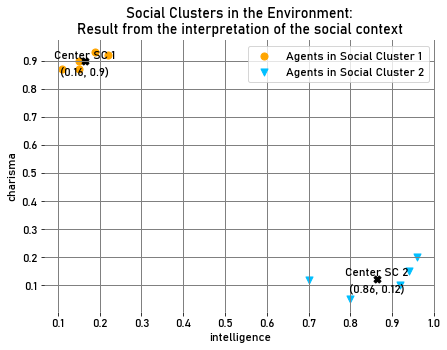

In [10]:
def printClustering():
    fig = plt.figure(figsize = (7,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
    plotStyle(ax)
    
    lenColorsClusters = len(colors)
    lenSymbolsAgents = len(plotSymbols)
    for i in range(0, clustersCt[0]):
        x = []
        y = []
        symbol = plotSymbols[i%lenSymbolsAgents]
        for j in range(0, len(dataAgents)):
            if(clustersCt[1][j] == i):
                #plotting the agents
                x.append(dataAgents[j][0])
                if (len(dataAgents[j]) > 1):
                    y.append(dataAgents[j][1])
                else:
                    y.append(0)
        color = colors[i%lenColorsClusters]
        plt.scatter(x, y, c=color, marker=symbol, s = 50, label="Agents in Social Cluster " + str(i+1))

    #plotting the centroids
    for c in range(0, len(clustersCt[2])):
        x = clustersCt[2][c][0]
        if (len(clustersCt[2][c]) > 1):
            y = clustersCt[2][c][1]
        else:
            y = 0
        plt.scatter(x, y, marker='X', s = 50, c='black')
        plt.annotate("Center SC " + str(c+1), (x, y+0.01), ha='center')
        plt.annotate("(" + str(np.around(x,2)) + ", " + str(np.around(y,2)) +")", (x, y-0.05), ha='center')

    plt.title('Social Clusters in the Environment:\nResult from the interpretation of the social context')
    theme = context.theme
    if len(theme) == 0:
        theme = context.agentsPresent[0].personalCharacteristics
    themeKeys = list(theme)  
    plt.xlabel(themeKeys[0])
    if (len(themeKeys) > 1):
        plt.ylabel(themeKeys[1])
    plt.legend(fancybox=True)           
    plt.show()


printClustering()

### Normative Fit <a id="normativeFit"></a>

During the normative fit, each agent will attempt to <b>identify the previous clusters</b> by verifying if they are <b>similar</b> to any group in their collection of <b>normative groups</b>.
The centroids of each cluster and the projection in the context of the prototypical characteristics of each normative group are compared. If this difference is below a given threshold, the cluster is identified as an instance of its closest normative group. 

$si_i = {NormativeFit(sc_i)} = 
\begin{cases} 
argmin(distance(sc_i,\forall_{sg \in NSG} sg))\text{, if $distance < tNormative$} \\ 
\emptyset\text{, otherwise} \\
\end{cases}$

<div id="norm-fit"></div>
We also computed the $dispersion$ of each cluster during this step to be used in the comparative fit step. The dispersion of a group is related to their intra-group differences and it can be computed by the <b>normalized average of absolute differences between the projection in the context of the personal characteristics of each group member and the group's centroid </b>(or context-filtered prototypical characteristics if it is a normative group).

$dispersion{(sg_{i})} = \frac{\sum\limits_{x=1}^{n} \left|P_{{a_x}_{Ctx}} - centroid({sg_{i}}) \right|}{n}, n = |A_{sg_i}|, a \in A_{sg_i}$

In [11]:
def dispersion(sg, agentsGroup): 
    diff = []
    #only calculate dispersion with agents that belong to the group
    for j in agentsGroup:
        diff.append(distanceWeights(dataAgents[j], sg))
    return np.mean(diff, axis=0)/thresholdNormative

Finally, we can define the normative fit.

In [12]:
def normativeFit(a, idxA):
    #verify if the characteristics of the normative social groups match with the context's theme
    matchSGs = []
    for sg in a.normativeGroups:
        match = True
        centroidSG = []
        theme = context.theme
        #when theme is empty
        if len(theme) == 0:
            theme = a.personalCharacteristics
        for t in theme:
            if t not in sg.characteristics:
                match = False
                sg.type = 0
            else:
                centroidSG.append(sg.characteristics[t])
        if match:
            matchSGs.append([sg, centroidSG])
            
    
    #distance centroids clusters to centroids social groups matching context KB
    for i, c in enumerate(clustersCt[2]):
        agentsGroup = []
        for j, l in enumerate(clustersCt[1]):
            if l == i:
                agentsGroup.append(j)
                
        #get dispersion of cluster
        dispersionGroup = dispersion(c, agentsGroup)
        
        #initial accessibility
        initAcc = 1 - distanceWeights(dataAgents[idxA], c)
        
        knownSG = False
        for m in matchSGs:
            #distance between cluster centroid and kb sg centroid
            distClusterKB = distanceWeights(m[1], c)
            #compare to threshold
            if distClusterKB < thresholdNormative:
                knownSG = True
                m[0].dispersion = dispersionGroup
                m[0].type = 1
                if m[0].accessibility is None:
                    m[0].accessibility = initAcc

        #new normative group (will only be considered as normative group in the next time step)
        if not knownSG: 
            name = "Group " + (str(len(a.normativeGroups) + 1))
            newSGchar = {}
            theme = context.theme
            if len(theme) == 0:
                theme = a.personalCharacteristics
            for idx, t in enumerate(theme):
                newSGchar[t] = c[idx]
            newSG = SocialGroup(name, newSGchar, initAcc)
            newSG.dispersion = dispersionGroup
            newSG.type = 1
            a.normativeGroups.append(newSG)

print("Before Normative Fit")
print(agents[0].normativeGroups)
print("After Normative Fit")
normativeFit(agents[0], 0)
print(agents[0].normativeGroups)


Before Normative Fit
[]
After Normative Fit
[<__main__.SocialGroup object at 0x0000021DFE385FD0>, <__main__.SocialGroup object at 0x0000021DFE3855B0>]


It is relevant to mention that ad-hoc groups (i.e., the agent does not have previous knowledge or past experiences with these groups) were already added to the agent's collection of normative groups in the previous code to simplify our model implementation. However, they are only considered normative for the following time this mechanism is executed. We will explain this update with more detail <a href="#init-acc">here</a>, as well as how this affects the salience computation.

$NSG = NSG \cup newsg: newsg = (randName, centroid(sc_i) , acc_{t=0})
$



### Comparative Fit <a id="comparativeFit"></a>

In the comparative fit step, the fitness of a particular social identity is determined by the distance between groups <b>(inter-group differences)</b> and their dispersion <b>(intra-group differences)</b>:

${fit}({si_i})= f(distance(sg_{in}, sg_{out}), dispersion(sg_{in}), dispersion(sg_{out})) = 
 \frac{distance(sg_{in},sg_{out})}{2} + \frac{(1 - dispersion{(sg_{in})}) + dispersion{(sg_{out})}}{4}:fit \in [0,1]$

The dispersion formula is described <a href="#norm-fit">here</a>. The distance is computed by the <b>normalized difference between the in-group centroids and the out-group centroids</b> (or their context-filtered prototypical characteristics, if they are normative groups).
Social groups with <b>higher fitness</b> have <b>less clustering dispersion</b> and <b>higher distance</b> from the other social groups.

$distance{(sg_{in},sg_{out})} = \left|centroid({sg_{out}}) - centroid({sg_{in}}) \right|$

In [13]:
#we are assuming that there can be more than one out-group
def dispersionCF(sg): 
    dispersion = []
    for i in sg:
        dispersion.append(i.dispersion)
    return np.mean(dispersion, axis=0)

def distanceCF(inGroup, outGroup):
    centroidIn = []
    for sg in inGroup:
        ct = []
        for c in sg.characteristics:
            ct.append(sg.characteristics[c])
        centroidIn.append(ct)
    centroidOut = []
    for sg in outGroup:
        ct = []
        for c in sg.characteristics:
            ct.append(sg.characteristics[c])
        centroidOut.append(ct)
        
    meanCentroidIn = np.mean(centroidIn, axis=0)
    meanCentroidOut = np.mean(centroidOut, axis=0)
    return distanceWeights(meanCentroidIn, meanCentroidOut)

def comparativeFit(a):
    presentGroups = []
    #Get present groups only
    for sg in a.normativeGroups:
        if sg.type == 1:
            presentGroups.append(sg)
            
    #there is more than one social group
    if (len(presentGroups)) > 1:
        for idx, g in enumerate(presentGroups):
            inGroup = [g]
            outGroup = [x for i,x in enumerate(presentGroups) if i!=idx]    
            #compute distance between in group and outgroup(s)
            distanceBetweenGroups = distanceCF(inGroup, outGroup) #in case theres more than one outgroup (or ingroup)
            #compute dispersion in group and out group(s)
            dispersionInGroup = dispersionCF(inGroup)
            dispersionOutGroup = dispersionCF(outGroup)
            #compute fitness
            fitness = distanceBetweenGroups/2 + ((1 - dispersionInGroup) + dispersionOutGroup)/4
            #update fitness for each sg
            g.fitness = fitness
    #only one social group - fitness is 0 - personal identity
    else:
        for g in presentGroups:
            g.fitness = 0
            
comparativeFit(agents[0])
print("Fitness " + agents[0].normativeGroups[0].name)
print(agents[0].normativeGroups[0].fitness)
print("Fitness " + agents[0].normativeGroups[1].name)
print(agents[0].normativeGroups[1].fitness)


Fitness Group 1
0.675162377156659
Fitness Group 2
0.5627658036306044


### Salience <a id="salience"></a>

Following the social clustering, the salience of each cluster in the environment needs to be computed given its fitness (formulas defined previously) and accessibility values.

$Salience(sc_i) = f ({fit}({si}_i), {acc}({si}_i)) = fit(si_{i}) \times acc(si_{i}), sc \in SC, si \in NSG:Salience \in [0,1]$

The <b>salient social identity</b> for each agent is the one with the <b>maximum value of salience</b>.

$SSI = argmax(\forall_{sc \in SC} Salience(sc))$

When making <b>actions and decisions</b>, agents will use their <b>personal identity</b> (if there is only one social group in the environment, meaning that no social identity is salient; or if the value of salience of the salient social identity is lower or equal to the threshold of the minimum salience), or their <b>salient social identity</b>. Agents will then redefine their self-concept based on this active identity, without ever losing their personal characteristics.

$AI = {ActiveIdentity(PI, SSI)} = 
\begin{cases}
PI\text{,} & \text{if } SSI == \emptyset \text{ or } Salience(SSI) \leq tSalience \\ 
SSI \text{,} & \text{otherwise} \\
\end{cases}$


If the cluster for which we are computing the salience is not normative, and thus no initial value of accessibility is available, its salience should be computed as the fitness multiplied by a value indicating how close the agent is from that cluster: the complement of the distance between the agent's context-filtered characteristics and the cluster's centroid. Its accessibility should also be initialized in the collection of normative groups with this value. (To simplify our code, we already initialized the accessibility during the normative fit). <div id="init-acc"></div>


In [14]:
def normalizeAccessibility(a):
    sumAcc = 0
    for sg in a.normativeGroups:
        if sg.accessibility is not None:
            sumAcc += sg.accessibility**2
    normAcc = np.sqrt(sumAcc)
    for sg in a.normativeGroups:
        if sg.accessibility is not None:
            sg.accessibility /= normAcc
        
def salienceSocialGroup(a, idxA):
    for sg in a.normativeGroups:
        if sg.type == 1:
            fitness = sg.fitness
            accessibility = sg.accessibility
            #compute salience 
            salience = fitness * accessibility
            #update salience for each sg
            sg.salience = salience

def salientActiveIdentity(a, idxAgent):
    salienceVal = 0
    identity = None
    identityName = "personal"
    presentGroups = []
    #Get present groups only
    for sg in a.normativeGroups:
        if sg.type == 1:
            presentGroups.append(sg)
    
    #more than one social group - social identity
    if len(presentGroups) > 1:
        #find social identity with highest salience
        for sg in presentGroups:
            auxVal = sg.salience
            if  auxVal > salienceVal:
                salienceVal = auxVal
                identity = sg
        if salienceVal > thresholdMinimalSalience: #only updating salient social identity again if its salience is above or equal to threshold        
            a.salientIdentity = identity
        else:
            a.salientIdentity = None
    else:
        a.salientIdentity = None    
    normalizeAccessibility(a)

        
salienceSocialGroup(agents[0], 0)
salientActiveIdentity(agents[0], 0)
if (agents[0].salientIdentity != None):
    print("Salient Identity")
    print(agents[0].salientIdentity.name)
    print("Salience")
    print(agents[0].salientIdentity.salience)


Salient Identity
Group 2
Salience
0.538521110827642


### Accessibility Update <a id="accUpdate"></a>


After performing an action or decision using a specific salient identity, each agent will update its accessibility. Then, the new accessibility value of an identity will be computed according to the previous accessibility and respective salience (and optionally an evaluated outcome), being this function like a <b>reinforcement mechanism</b>. 

$acc_{(SSI)_{t+1}} = f(acc_{(SSI)_{t}}, Salience{(SSI)_{t}}, opt_{evaluatedOutcome})$
    
In this stage, the accessibility values of all identities present in an agent's knowledge base must be normalized as well, so that when one identity's accessibility increases, all the others suffer a decay.
This <b>update function can be altered depending on the scenarios</b> tested with the model.

In [15]:
def updateAccessibility(a, constant = 0.01):
    sid = a.salientIdentity    
    if sid is not None:
        prevAccessibility = sid.accessibility
        newAccessibility  = prevAccessibility + sid.salience * constant
        sid.accessibility = newAccessibility
    normalizeAccessibility(a)
        
print("Previous accessibility")
print(agents[0].normativeGroups[0].accessibility)
print(agents[0].normativeGroups[1].accessibility)
updateAccessibility(agents[0])
print("New accessibility")
print(agents[0].normativeGroups[0].accessibility)
print(agents[0].normativeGroups[1].accessibility)

Previous accessibility
0.22668443980779898
0.9739682565407481
New accessibility
0.2255015116689159
0.9742428179027207


### Setup <a id="setup"></a>

The DIMA module can be embedded in a standard social agent architecture. In the <b>perception module</b>, the agent identifies the context and agents in the environment. This is provided as input to the <b>DIMA module</b>, which returns an active identity and its salience. In turn, the DIMA output is given to the <b>decision-making module</b>, allowing the agent to determine the proper action. This action will have an outcome in the environment, which can be evaluated by the agent in the perception module, resulting in a value used in the accessibility update of the active social identity. Additionally, the agent's knowledge base includes the agent's normative groups.

<h3 align="center">DIMA integrated in social agent architecture</h3>

<img src="DIMA_figures/dimaModel_agentElements.png" width=50% align="center">

Auxiliary functions for the plots.

In [16]:
def listGraphics(a, s, r):
    for sg in a.normativeGroups:
        if sg.type == 1:
            salience = sg.salience if sg.salience is not None else 0
            accessibility = sg.accessibility if sg.accessibility is not None else 0
            if sg.salienceSteps == []:
                sg.salienceSteps = [0] * numSteps
            if sg.accessibilitySteps == []:
                sg.accessibilitySteps = [0] * numSteps
            sg.salienceSteps[s] += salience
            sg.accessibilitySteps[s] += accessibility
            if (s == numSteps - 1):
                if len(sg.accessibilityFinalStep) == 0:
                    sg.accessibilityFinalStep = [0] * numRuns
                sg.accessibilityFinalStep[r] = accessibility
                if len(sg.salienceFinalStep) == 0:
                    sg.salienceFinalStep = [0] * numRuns
                sg.salienceFinalStep[r] = salience
        
def clearSim():
    for a in context.agentsPresent:
        for sg in a.normativeGroups:
            if sg.type == 1:
                sg.fitness = None
                sg.accessibility = None
                sg.salience = None
                sg.type = 0


In [17]:
#Perception Module functions here (perceive agents and context)
#Agents and Context - provided manually by JSON File
agents = initAgents(agentsFile)
context = initContext(contextFile, agents)
#Simulation Variables
numSteps = 100
numRuns = 30 #used to repeat the simulations

def cycle():
    #DIMA Module functions
    #outside of "for", because it will result in the same clusters every time, for this example
    global clustersCt
    clustersCt = clustering()
    for r in range(0, numRuns):
        for s in range(0, numSteps):
            #For each agent        
            for idxAgent, a in enumerate(context.agentsPresent):
                normativeFit(a, idxAgent)
                comparativeFit(a)
                salienceSocialGroup(a, idxAgent)
                salientActiveIdentity(a, idxAgent)
                listGraphics(a, s, r)
                #Decision Making functions here (decide on proper action)
                #Perception Module functions here (evaluate outcome)
                updateAccessibility(a)
        clearSim()
        print("simulation " + str(r))
cycle()

simulation 0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
simulation 11
simulation 12
simulation 13
simulation 14
simulation 15
simulation 16
simulation 17
simulation 18
simulation 19
simulation 20
simulation 21
simulation 22
simulation 23
simulation 24
simulation 25
simulation 26
simulation 27
simulation 28
simulation 29


### Salience and Accessibility Plots <a id="plots"></a>

The following plot shows how the salience and accessibility of the salient social identity varies.

Salience and Accessibility Plots
Cluster 1
Step = 100
Salience
Mean: 0.668777786586476
Standard Deviation: 3.3306690738754696e-16
Accessibility
Mean: 0.9905436221178822
Standard Deviation: 4.440892098500626e-16
Cluster 2
Step = 100
Salience
Mean: 0.5553921422721584
Standard Deviation: 3.3306690738754696e-16
Accessibility
Mean: 0.9868974601674874
Standard Deviation: 4.440892098500626e-16


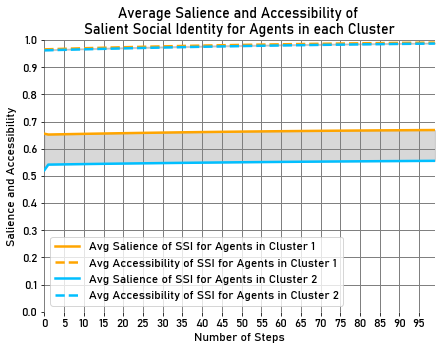

In [18]:
from scipy import stats

def meanF(data):
    n = len(data)
    return sum(data)/n

def variance(data, ddof=0):
    n = len(data)
    mean = meanF(data)
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

def stdev(data):
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev

def showSalienceAccessibilityPlots():
    numGroups = len(clustersCt[2])
    lenColors = len(colors)
    fig = plt.figure(figsize = (7,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    plotStyle(ax)
    sP = []
    aP = []
    for sg in range(0, clustersCt[0]):           
        agentsGroup = []
        currCluster = 0
        for a, c in enumerate(clustersCt[1]):
            if c == sg:
                currCluster = c
                agentsGroup.append(context.agentsPresent[a])
        lenAgents = len(agentsGroup)
        salienceSimsAgents = [0]*numSteps
        accessibilitySimsAgents = [0]*numSteps
        salienceFinalStepAgents = [0]*numRuns
        accessibilityFinalStepAgents = [0]*numRuns
        for agent in agentsGroup:                
            #plot - scale axis
            sgKB = agent.normativeGroups[currCluster]
            salienceSimsAgents += np.array([x / numRuns for x in sgKB.salienceSteps])
            accessibilitySimsAgents += np.array([x / numRuns for x in sgKB.accessibilitySteps])
            salienceFinalStepAgents += np.array([x for x in sgKB.salienceFinalStep])
            accessibilityFinalStepAgents += np.array([x for x in sgKB.accessibilityFinalStep])
        #mean and stdDev
        salienceAccessibilityMeanStdDev(sg, np.array(salienceFinalStepAgents/lenAgents), np.array(accessibilityFinalStepAgents/lenAgents))
        colorPlot = colors[sg%lenColors]
        salienceSims = np.array(salienceSimsAgents/lenAgents)
        plt.plot(salienceSims, color=colorPlot, linewidth=2.5, label='Avg Salience of SSI for Agents in Cluster ' + str(sg+1))
        accessibilitySims = np.array(accessibilitySimsAgents/lenAgents)             
        plt.plot(accessibilitySims,'--', linewidth=2.5, color=colorPlot, label='Avg Accessibility of SSI for Agents in Cluster ' + str(sg+1))
        sP.append(salienceSims)
        aP.append(accessibilitySims)
    plt.title('Average Salience and Accessibility of \nSalient Social Identity for Agents in each Cluster')
    if len(sP) == 2:
        plt.fill_between(np.arange(numSteps), sP[0], sP[1], color="grey", alpha=0.3)
    if len(aP) == 2:
        plt.fill_between(np.arange(numSteps), aP[0], aP[1], color="grey", alpha=0.3)
    plt.legend(fancybox=True)
    plt.xlim(0, numSteps-1) 
    plt.ylim(0, 1)
    plt.xlabel("Number of Steps")
    plt.ylabel("Salience and Accessibility")                    
    plt.show()

def salienceAccessibilityMeanStdDev(sg, dataSal, dataAcc):
    print("Cluster " + str(sg+1))
    print("Step = 100")
    print("Salience")
    print("Mean: " + str(meanF(dataSal)))
    print("Standard Deviation: " + str(stdev(dataSal)))
    print("Accessibility")
    print("Mean: " + str(meanF(dataAcc)))
    print("Standard Deviation: " + str(stdev(dataAcc)))
        
print("Salience and Accessibility Plots")
showSalienceAccessibilityPlots()


## Conclusion <a id="conclusion"></a>

In this notebook, we presented the Dynamic Identity Model for Agents, a model grounded on the Social Identity Approach. We provided an overview of the model formalization, explaining how it can be integrated with other components as well. We created a scenario exemplifying this, which is available as an additional notebook on GitHub (https://github.com/GAIPS/dynamic-identity-model-for-agents).

For any questions, please feel free to contact us using this email: ines.lobo@tecnico.ulisboa.pt